In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import numpy as np
import ipyplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from collections import defaultdict
import os

In [3]:
from tensorflow_similarity.samplers import SingleShotMemorySampler
from tensorflow_similarity.augmenters import SimCLRAugmenter
from tensorflow_similarity.models import ContrastiveModel
from tensorflow_similarity.losses import SiamSiamLoss
from tensorflow_similarity.training_metrics import encoder_std  ## siam siam metric
from tensorflow_similarity.visualization import visualize_views


# dataset

## loading

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
print("x_train", x_train.shape, "x_test", x_test.shape)
y_train = keras.utils.to_categorical(y_train, 100)
y_test = keras.utils.to_categorical(y_test, 100)
print("y_train", y_train.shape, "y_test", y_test.shape)

x_train (50000, 32, 32, 3) x_test (10000, 32, 32, 3)
y_train (50000, 100) y_test (10000, 100)


In [5]:
IMG_SIZE = 32
PRE_TRAIN_IMGS = 128
TRAIN_BATCH_SIZE = 64

In [6]:
train_augmenter = SimCLRAugmenter(IMG_SIZE,IMG_SIZE, is_training=True)
#     #test_augmenter = SimCLRAugmenter(IMG_SIZE,IMG_SIZE, is_training=False)
sampler = SingleShotMemorySampler(x_train, examples_per_batch=PRE_TRAIN_IMGS, augmenter=train_augmenter, num_augmentations_per_example=2)


The initial batch size is 384 (128 classes * 1 examples per class) with 2 augmenters


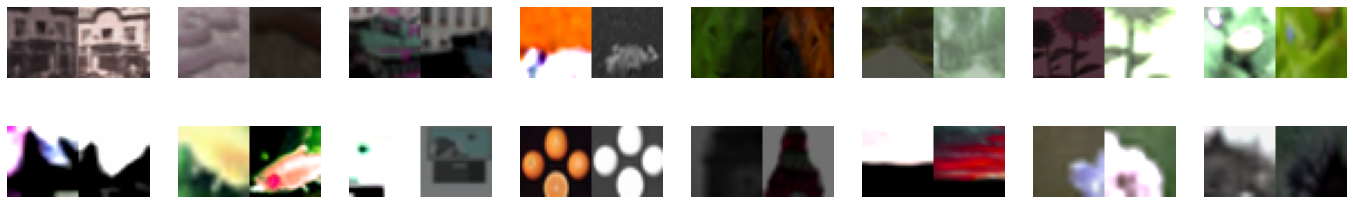

In [7]:
views = sampler.generate_batch(0)

visualize_views(views=views, num_imgs=16, views_per_col=8)

# Models

## backbone 

In [ ]:
def get_encoder(IMG_SIZE, trainable=True):
	base_model = tf.keras.applications.ResNet50V2(include_top=False,
		weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
	base_model.trainable = trainable

	inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
	# no rescaling as efficientnet do it for you
	x = base_model(inputs, training=True)
 
 	# < this is the representation
	o = layers.GlobalAveragePooling2D()(x) 
	backbone = Model(inputs, o, name='encoder')
	return backbone
encoder = get_encoder(IMG_SIZE)
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________


## projector model

In [9]:
def get_projector(dim, activation='relu'):
    inputs = layers.Input(shape=(dim,))
    x = layers.Dense(dim, activation=activation)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(dim, activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(dim)(x)
    x = layers.BatchNormalization()(x)
    projector = Model(inputs, x, name="projector")
    return projector

projector = get_projector(2048)
projector.summary()

Model: "projector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              81

# Loss

In [10]:
loss = SiamSiamLoss
metrics = [[encoder_std], []]

In [11]:
PRE_TRAIN_EPOCHS = 20
STEPS_PER_EPOCH = 200
contrastive_model = ContrastiveModel(encoder_model=encoder, 
                         projector_model=projector, 
                         swap_representation=True)
# use sgd as optimizer with constant loss as recommende in the paper.
contrastive_model.compile('sgd', loss=SiamSiamLoss, metrics=metrics)
contrastive_history = contrastive_model.fit(sampler, epochs=PRE_TRAIN_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/20
200/200 [==============================] - 49s 193ms/step - loss: 1.2496 - output_1_encoder_std: 0.0182
Warmup complete
Epoch 2/20
200/200 [==============================] - 41s 198ms/step - loss: 0.9045 - output_1_encoder_std: 0.0182
Epoch 3/20
200/200 [==============================] - 44s 220ms/step - loss: 0.8625 - output_1_encoder_std: 0.0182
Epoch 4/20
200/200 [==============================] - 41s 204ms/step - loss: 0.8400 - output_1_encoder_std: 0.0181
Epoch 5/20
200/200 [==============================] - 40s 201ms/step - loss: 0.8227 - output_1_encoder_std: 0.0181
Epoch 6/20
200/200 [==============================] - 41s 202ms/step - loss: 0.8066 - output_1_encoder_std: 0.0181
Epoch 7/20
200/200 [==============================] - 42s 207ms/step - loss: 0.7927 - output_1_encoder_std: 0.0181
Epoch 8/20
200/200 [==============================] - 42s 210ms/step - loss: 0.7767 - output_1_encoder_std: 0.0180
Epoch 9/20
200/200 [==============================] - 41s 203ms/

# Evaluation

In [58]:
TEST_EPOCHS = 20
LR = 0.01
# allows to use a fraction of the dataset via select_sample
x_restricted = x_train[:10000]
y_restricted = y_test[:10000]

In [59]:
def get_model(IMG_SIZE, decoder, LR, training):
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = decoder(inputs, training=training)
    o = layers.Dense(256, activation='relu')(x)
    o = layers.BatchNormalization()(o)
    o = layers.Dense(100, activation='softmax')(o)
    model = Model(inputs, o, name='no_pretrain')
    optim = SGD(LR)
    model.compile(optim, loss='categorical_crossentropy', metrics=['acc'])
    return model

# No pretrain

In [60]:
reg_model = get_model(IMG_SIZE, get_encoder(IMG_SIZE), LR, training=True)
reg_history = reg_model.fit(x_restricted, y_restricted, batch_size=TRAIN_BATCH_SIZE, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/20
157/157 [==============================] - 11s 50ms/step - loss: 4.9748 - acc: 0.0090 - val_loss: 4.7925 - val_acc: 0.0110
Epoch 2/20
157/157 [==============================] - 8s 50ms/step - loss: 4.6840 - acc: 0.0142 - val_loss: 4.7354 - val_acc: 0.0104
Epoch 3/20
157/157 [==============================] - 7s 42ms/step - loss: 4.5805 - acc: 0.0214 - val_loss: 4.7062 - val_acc: 0.0110
Epoch 4/20
157/157 [==============================] - 7s 43ms/step - loss: 4.5154 - acc: 0.0279 - val_loss: 4.7384 - val_acc: 0.0095
Epoch 5/20
157/157 [==============================] - 7s 45ms/step - loss: 4.4823 - acc: 0.0334 - val_loss: 4.7687 - val_acc: 0.0099
Epoch 6/20
157/157 [==============================] - 7s 43ms/step - loss: 4.4281 - acc: 0.0419 - val_loss: 4.8122 - val_acc: 0.0081
Epoch 7/20
157/157 [==============================] - 7s 46ms/step - loss: 4.4058 - acc: 0.0441 - val_loss: 4.8175 - val_acc: 0.0123
Epoch 8/20
157/157 [==============================] - ETA: 0s - loss

KeyboardInterrupt: 

In [ ]:
# pretrained with SiamSiam

In [64]:
encoder = contrastive_model.get_encoder()
encoder.trainable = False
pre_model = get_model(IMG_SIZE, encoder, 0.001, training=False)

pre_model.compile('adam', loss='categorical_crossentropy', metrics=['acc'])
pre_history = pre_model.fit(x_restricted, y_restricted, batch_size=TRAIN_BATCH_SIZE, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/20
157/157 [==============================] - 7s 27ms/step - loss: 4.6598 - acc: 0.0088 - val_loss: 4.6631 - val_acc: 0.0109
Epoch 2/20
157/157 [==============================] - 4s 24ms/step - loss: 4.6235 - acc: 0.0118 - val_loss: 4.6347 - val_acc: 0.0104
Epoch 3/20
157/157 [==============================] - 4s 24ms/step - loss: 4.6197 - acc: 0.0105 - val_loss: 4.6255 - val_acc: 0.0093
Epoch 4/20
157/157 [==============================] - 4s 23ms/step - loss: 4.6167 - acc: 0.0101 - val_loss: 4.6324 - val_acc: 0.0116
Epoch 5/20
157/157 [==============================] - 4s 23ms/step - loss: 4.6137 - acc: 0.0105 - val_loss: 4.6364 - val_acc: 0.0081
Epoch 6/20
157/157 [==============================] - 5s 29ms/step - loss: 4.6108 - acc: 0.0105 - val_loss: 4.6507 - val_acc: 0.0122
Epoch 7/20
157/157 [==============================] - 4s 25ms/step - loss: 4.6099 - acc: 0.0133 - val_loss: 4.6389 - val_acc: 0.0081
Epoch 8/20
157/157 [==============================] - 3s 22ms/step - 

KeyboardInterrupt: 

In [ ]:
print('no pretrain', reg_model.evaluate(x_test, y_test))
print('pretrained', pre_model.evaluate(x_test, y_test))